Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

import timeit

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = '../1_notmnist/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Logistic regression
First the graph for logistic regression with L2 regularization

In [9]:
batch_size = 128
L2_reg = 0.001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 18.799061
Minibatch accuracy: 6.2%
Validation accuracy: 11.3%
Minibatch loss at step 500: 2.526260
Minibatch accuracy: 78.9%
Validation accuracy: 77.1%
Minibatch loss at step 1000: 2.024815
Minibatch accuracy: 74.2%
Validation accuracy: 79.3%
Minibatch loss at step 1500: 1.113453
Minibatch accuracy: 79.7%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 0.825109
Minibatch accuracy: 85.9%
Validation accuracy: 81.3%
Minibatch loss at step 2500: 0.721640
Minibatch accuracy: 82.0%
Validation accuracy: 82.0%
Minibatch loss at step 3000: 0.705919
Minibatch accuracy: 84.4%
Validation accuracy: 81.8%
Test accuracy: 88.4%


L2 regularization - BETA parameter, iterate and change beta parameter.

In [7]:
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : L2_reg}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

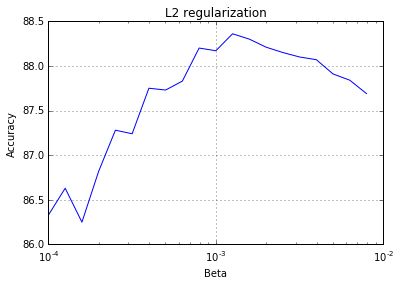

In [8]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('L2 regularization')
plt.xlabel('Beta')
plt.ylabel('Accuracy')
plt.show()

### Neural network

Graph for NN

In [11]:
batch_size = 128
L2_reg = 0.001
n_hidden = 1024 # Number of hidden nodes

g = tf.Graph()
with g.as_default():
    
    # Placehodlers for training dataset minibatches
    tf_train_dataset = tf.placeholder(np.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(np.float32, shape=(batch_size, num_labels))
    beta_regul = tf.placeholder(tf.float32)
    
    # Constants for validation and test datasets
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Define weights and biases as variables for hidden layer
    W_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden]))
    b_1 = tf.Variable(tf.zeros([n_hidden]))
    
    # Define weights and biases as variables for logistic regression layer
    W_0 = tf.Variable(
        tf.truncated_normal([n_hidden, num_labels]))
    b_0 = tf.Variable(tf.zeros([num_labels]))
    
    logits_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1) # shape will be (batch_size, n_hidden)
    
    logits_0 = tf.matmul(logits_1, W_0) + b_0 # now the shape is (batch_size, num_labels)
    
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_0)
            + beta_regul * (tf.nn.l2_loss(W_0) + tf.nn.l2_loss(W_1)))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits_0)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1), W_0) + b_0)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1), W_0) + b_0)

In [12]:
n_steps = 3001 # number of steps to be taken

with tf.Session(graph=g) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(n_steps):
        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Prepare minibatch data
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : L2_reg}
        _, l, predictions = sess.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch  train and validation accuracy: %.1f%%, %.1f%%" 
                % (accuracy(predictions, batch_labels), 
                accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 625.662354
Minibatch  train and validation accuracy: 10.2%, 21.0%
Minibatch loss at step 500: 194.075836
Minibatch  train and validation accuracy: 82.0%, 81.1%
Minibatch loss at step 1000: 116.826126
Minibatch  train and validation accuracy: 82.8%, 82.2%
Minibatch loss at step 1500: 68.664917
Minibatch  train and validation accuracy: 85.2%, 83.2%
Minibatch loss at step 2000: 41.477554
Minibatch  train and validation accuracy: 89.1%, 85.2%
Minibatch loss at step 2500: 25.186268
Minibatch  train and validation accuracy: 91.4%, 86.5%
Minibatch loss at step 3000: 15.563068
Minibatch  train and validation accuracy: 90.6%, 87.3%
Test accuracy: 92.8%


---
Problem 2
---------
Let's demonstrate an extreme case of **overfitting**. Restrict your training data to just a few batches. What happens?

---

In [21]:
batch_size = 128 # batch size reduced
n_hidden = 1024 # Number of hidden nodes
L2_reg = 0.000 # ratio for L2 regularization (use no regularization here)

g = tf.Graph()
with g.as_default():
    
    # Placehodlers for training dataset minibatches
    tf_train_dataset = tf.placeholder(np.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(np.float32, shape=(batch_size, num_labels))
    beta_regul = tf.placeholder(tf.float32)
    
    # Constants for validation and test datasets
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Define weights and biases as variables for hidden layer
    W_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden]))
    b_1 = tf.Variable(tf.zeros([n_hidden]))
    
    # Define weights and biases as variables for logistic regression layer
    W_0 = tf.Variable(
        tf.truncated_normal([n_hidden, num_labels]))
    b_0 = tf.Variable(tf.zeros([num_labels]))
    
    logits_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1) # shape will be (batch_size, n_hidden)
    
    logits_0 = tf.matmul(logits_1, W_0) + b_0 # now the shape is (batch_size, num_labels)
    
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_0)
            + beta_regul * (tf.nn.l2_loss(W_0) + tf.nn.l2_loss(W_1)))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits_0)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1), W_0) + b_0)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1), W_0) + b_0)

In [24]:
n_steps = 3001 # number of steps to be taken
mod_batches = 3 # just use first a few batches over and over again

with tf.Session(graph=g) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(n_steps):
        
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # 0, 128, 0, 128, ...
        offset = (step * batch_size) % (mod_batches * batch_size - batch_size)

        # Prepare minibatch data
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : L2_reg}
        _, l, predictions = sess.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch  train and validation accuracy: %.1f%%, %.1f%%" 
                % (accuracy(predictions, batch_labels), 
                accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))



Initialized
Minibatch loss at step 0: 303.187195
Minibatch  train and validation accuracy: 10.2%, 24.0%
Minibatch loss at step 500: 0.000000
Minibatch  train and validation accuracy: 100.0%, 71.2%
Minibatch loss at step 1000: 0.000000
Minibatch  train and validation accuracy: 100.0%, 71.2%
Minibatch loss at step 1500: 0.000000
Minibatch  train and validation accuracy: 100.0%, 71.2%
Minibatch loss at step 2000: 0.000000
Minibatch  train and validation accuracy: 100.0%, 71.2%
Minibatch loss at step 2500: 0.000000
Minibatch  train and validation accuracy: 100.0%, 71.2%
Minibatch loss at step 3000: 0.000000
Minibatch  train and validation accuracy: 100.0%, 71.2%
Test accuracy: 78.3%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [25]:
batch_size = 128 # batch size reduced
n_hidden = 1024 # Number of hidden nodes
L2_reg = 0.000 # ratio for L2 regularization (use no regularization here)

g = tf.Graph()
with g.as_default():
    
    # Placehodlers for training dataset minibatches
    tf_train_dataset = tf.placeholder(np.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(np.float32, shape=(batch_size, num_labels))
    beta_regul = tf.placeholder(tf.float32)
    
    # Constants for validation and test datasets
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Define weights and biases as variables for hidden layer
    W_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden]))
    b_1 = tf.Variable(tf.zeros([n_hidden]))
    
    # Define weights and biases as variables for logistic regression layer
    W_0 = tf.Variable(
        tf.truncated_normal([n_hidden, num_labels]))
    b_0 = tf.Variable(tf.zeros([num_labels]))
    
    logits_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1) # shape will be (batch_size, n_hidden)
    
    # DROPOUT
    dropout_1 = tf.nn.dropout(logits_1, 0.5)
    
    logits_0 = tf.matmul(dropout_1, W_0) + b_0 # now the shape is (batch_size, num_labels)
    
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_0)
            + beta_regul * (tf.nn.l2_loss(W_0) + tf.nn.l2_loss(W_1)))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits_0)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1), W_0) + b_0)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1), W_0) + b_0)

In [26]:
n_steps = 3001 # number of steps to be taken
mod_batches = 3 # just use first a few batches over and over again

with tf.Session(graph=g) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(n_steps):
        
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # 0, 128, 0, 128, ...
        offset = (step * batch_size) % (mod_batches * batch_size - batch_size)

        # Prepare minibatch data
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : L2_reg}
        _, l, predictions = sess.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch  train and validation accuracy: %.1f%%, %.1f%%" 
                % (accuracy(predictions, batch_labels), 
                accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 542.402039
Minibatch  train and validation accuracy: 8.6%, 22.1%
Minibatch loss at step 500: 0.000000
Minibatch  train and validation accuracy: 100.0%, 74.9%
Minibatch loss at step 1000: 0.000000
Minibatch  train and validation accuracy: 100.0%, 74.4%
Minibatch loss at step 1500: 0.000000
Minibatch  train and validation accuracy: 100.0%, 74.2%
Minibatch loss at step 2000: 0.000000
Minibatch  train and validation accuracy: 100.0%, 74.9%
Minibatch loss at step 2500: 0.000000
Minibatch  train and validation accuracy: 100.0%, 74.5%
Minibatch loss at step 3000: 0.000000
Minibatch  train and validation accuracy: 100.0%, 75.3%
Test accuracy: 81.3%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


### Model with 1 hidden layer

Using ***learning rate decay***

In [27]:
n_hidden = 1024 # Number of hidden nodes
batch_size = 500
L2_reg = 0.001 # ratio for L2 regularization

g = tf.Graph()
with g.as_default():
    
    # Placehodlers for training dataset minibatches
    tf_train_dataset = tf.placeholder(np.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(np.float32, shape=(batch_size, num_labels))
    
    # Constants for validation and test datasets
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Use learning rate decay
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.95, staircase=True)
    
    # Define Weights and biases as variables for hidden layer
    W_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, n_hidden])
    )
    b_1 = tf.Variable(tf.zeros([n_hidden]))
    
    # Define Weights and biases as variables for logistic regression layer
    W_0 = tf.Variable(
        tf.truncated_normal([n_hidden, num_labels]))
    b_0 = tf.Variable(tf.zeros([num_labels]))
    
    logits_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1) # shape will be (batch_size, n_hidden)
    
    dropout_1 = tf.nn.dropout(logits_1, 0.5)
    
    logits_0 = tf.matmul(dropout_1, W_0) + b_0 # now the shape is (batch_size, num_labels)
    
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_0)
            + L2_reg * (tf.nn.l2_loss(W_0) + tf.nn.l2_loss(W_1)))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(tf.matmul(logits_1, W_0) + b_0)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1), W_0) + b_0)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1), W_0) + b_0)

Using ***early stopping*** for preventing overfitting

In [34]:
n_epochs = 200 # number of epochs

# early-stopping parameters
patience = 5000 # look as this many examples regardless
patience_increase = 2
improvement_threshold = 0.995 # a relative improvement of 
                                  # this much is considered significant
best_valid_loss = np.inf
start_time = timeit.default_timer()

n_train_batches = train_dataset.shape[0] // batch_size

valid_freq = min(n_train_batches, patience // 2)

with tf.Session(graph=g) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    done_looping = False
    epoch = 0
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            
            batch_data = \
                train_dataset[minibatch_index * batch_size:(minibatch_index + 1) * batch_size, :]
            batch_labels = \
                train_labels[minibatch_index * batch_size:(minibatch_index + 1) * batch_size, :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = sess.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            iter = (epoch - 1) * n_train_batches + minibatch_index # cumulative iteration number
        
            if (iter + 1) % valid_freq == 0:
                this_valid_loss = 1. - (accuracy(valid_prediction.eval(), valid_labels) / 100.)
            
                print("Minibatch loss at epoch %i and iter %i: %f and learning rate: %f" % 
                      (epoch, iter, l, sess.run(learning_rate)))
                print("Minibatch  train and validation accuracy: %.1f%%, %.1f%%" 
                    % (accuracy(predictions, batch_labels), 
                    accuracy(valid_prediction.eval(), valid_labels)))
            
                if this_valid_loss < best_valid_loss:
                    if this_valid_loss < best_valid_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)
                    
                    best_valid_loss = this_valid_loss
                    
                    params = (sess.run(W_0), sess.run(b_0),
                              sess.run(W_1), sess.run(b_1))
                    
                    # save the best model
                    with open('best_model_params.pkl', 'wb') as f:
                            pickle.dump(params, f)
                    print('Model saved')
        
            if patience <= iter:
                    done_looping = True
                    break
                    
    print("Final Test accuracy: %.1f%%" 
                  % accuracy(test_prediction.eval(), test_labels))
    
    with open('best_model_params.pkl', 'rb') as f:
        W_0_best, b_0_best, W_1_best, b_1_best = pickle.load(f)
        
    W_0_init, b_0_init = tf.assign(W_0, W_0_best), tf.assign(b_0, b_0_best)
    W_1_init, b_1_init = tf.assign(W_1, W_1_best), tf.assign(b_1, b_1_best)
    
    sess.run([W_0_init, b_0_init, W_1_init, b_1_init])
    
    print("Test accuracy with the best model: %.1f%%" 
                  % accuracy(test_prediction.eval(), test_labels))

    end_time = timeit.default_timer()

    print('Total run time %.4f minutes' % ((end_time - start_time) / 60.))

Initialized
Minibatch loss at epoch 1 and iter 399: 213.277390 and learning rate: 0.500000
Minibatch  train and validation accuracy: 77.8%, 83.7%
Model saved
Minibatch loss at epoch 2 and iter 799: 139.336838 and learning rate: 0.500000
Minibatch  train and validation accuracy: 78.0%, 83.3%
Minibatch loss at epoch 3 and iter 1199: 93.772942 and learning rate: 0.475000
Minibatch  train and validation accuracy: 77.2%, 82.2%
Minibatch loss at epoch 4 and iter 1599: 63.605476 and learning rate: 0.475000
Minibatch  train and validation accuracy: 79.0%, 85.0%
Model saved
Minibatch loss at epoch 5 and iter 1999: 43.537388 and learning rate: 0.451250
Minibatch  train and validation accuracy: 81.6%, 85.6%
Model saved
Minibatch loss at epoch 6 and iter 2399: 30.399555 and learning rate: 0.451250
Minibatch  train and validation accuracy: 82.4%, 86.3%
Model saved
Minibatch loss at epoch 7 and iter 2799: 21.327969 and learning rate: 0.451250
Minibatch  train and validation accuracy: 82.8%, 86.8%
Mo

Minibatch loss at epoch 60 and iter 23999: 0.541067 and learning rate: 0.145994
Minibatch  train and validation accuracy: 87.8%, 90.2%
Minibatch loss at epoch 61 and iter 24399: 0.557529 and learning rate: 0.145994
Minibatch  train and validation accuracy: 88.0%, 90.3%
Minibatch loss at epoch 62 and iter 24799: 0.540887 and learning rate: 0.145994
Minibatch  train and validation accuracy: 88.0%, 90.2%
Minibatch loss at epoch 63 and iter 25199: 0.567110 and learning rate: 0.138695
Minibatch  train and validation accuracy: 87.8%, 90.3%
Minibatch loss at epoch 64 and iter 25599: 0.541678 and learning rate: 0.138695
Minibatch  train and validation accuracy: 88.0%, 90.3%
Model saved
Minibatch loss at epoch 65 and iter 25999: 0.545184 and learning rate: 0.131760
Minibatch  train and validation accuracy: 87.8%, 90.3%
Minibatch loss at epoch 66 and iter 26399: 0.535162 and learning rate: 0.131760
Minibatch  train and validation accuracy: 87.8%, 90.2%
Minibatch loss at epoch 67 and iter 26799: 

Minibatch loss at epoch 121 and iter 48399: 0.533165 and learning rate: 0.042629
Minibatch  train and validation accuracy: 88.6%, 90.4%
Minibatch loss at epoch 122 and iter 48799: 0.535274 and learning rate: 0.042629
Minibatch  train and validation accuracy: 88.8%, 90.4%
Minibatch loss at epoch 123 and iter 49199: 0.528526 and learning rate: 0.040497
Minibatch  train and validation accuracy: 88.4%, 90.5%
Model saved
Minibatch loss at epoch 124 and iter 49599: 0.541369 and learning rate: 0.040497
Minibatch  train and validation accuracy: 88.8%, 90.5%
Minibatch loss at epoch 125 and iter 49999: 0.541893 and learning rate: 0.038472
Minibatch  train and validation accuracy: 88.6%, 90.4%
Minibatch loss at epoch 126 and iter 50399: 0.521251 and learning rate: 0.038472
Minibatch  train and validation accuracy: 88.8%, 90.4%
Minibatch loss at epoch 127 and iter 50799: 0.522927 and learning rate: 0.038472
Minibatch  train and validation accuracy: 88.4%, 90.5%
Minibatch loss at epoch 128 and iter

### Model with two hidden layers

Now let's try a model with 2 hidden layers. 

Weights with truncated normal distribution won't work here, thus we will initialize the weights with [Xavier initialization](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/).

In [39]:
n_hidden_2 = 1024 # Number of hidden nodes for hidden layer 2
n_hidden_1 = 500  # Number of hidden nodes for hidden layer 1
batch_size = 128
L2_reg = 0.000 # ratio for L2 regularization

g = tf.Graph()
with g.as_default():
    
    # Placehodlers for training dataset minibatches
    tf_train_dataset = tf.placeholder(np.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(np.float32, shape=(batch_size, num_labels))
    
    # Constants for validation and test datasets
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Use learning rate decay
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 5000, 0.95, staircase=True)
    
    # Define Weights and biases as variables for hidden layers
    W_2 = tf.get_variable("W2", shape=[image_size * image_size, n_hidden_2],
                                initializer=tf.contrib.layers.xavier_initializer())
    b_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    W_1 = tf.get_variable("W1", shape=[n_hidden_2, n_hidden_1],
                                initializer=tf.contrib.layers.xavier_initializer())
    b_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # Define Weights and biases as variables for logistic regression layer
    W_0 = tf.get_variable("W0", shape=[n_hidden_1, num_labels],
                                initializer=tf.contrib.layers.xavier_initializer())
    b_0 = tf.Variable(tf.zeros([num_labels]))
    
    logits_2 = tf.nn.relu(tf.matmul(tf_train_dataset, W_2) + b_2) # shape will be (batch_size, n_hidden_2)
    
    dropout_2 = tf.nn.dropout(logits_2, 0.5)
    
    logits_1 = tf.nn.relu(tf.matmul(dropout_2, W_1) + b_1) # shape will be (batch_size, n_hidden_1)
    
    dropout_1 = tf.nn.dropout(logits_1, 0.5)
    
    logits_0 = tf.matmul(dropout_1, W_0) + b_0 # now the shape is (batch_size, num_labels)
    
    loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_0)
            + L2_reg * (tf.nn.l2_loss(W_0) + tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2)))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    def get_logits(dataset):
        get_logits_2 = tf.nn.relu(tf.matmul(dataset, W_2) + b_2)
        get_logits_1 = tf.nn.relu(tf.matmul(get_logits_2, W_1) + b_1)
        get_logits_0 = tf.matmul(get_logits_1, W_0) + b_0
        return get_logits_0

    train_prediction = tf.nn.softmax(get_logits(tf_train_dataset))
    valid_prediction = tf.nn.softmax(get_logits(tf_valid_dataset))
    test_prediction = tf.nn.softmax(get_logits(tf_test_dataset))

In [46]:
n_epochs = 200 # number of epochs

# early-stopping parameters
patience = 5000 # look as this many examples regardless
patience_increase = 2
improvement_threshold = 0.995 # a relative improvement of 
                                  # this much is considered significant
best_valid_loss = np.inf
start_time = timeit.default_timer()

n_train_batches = train_dataset.shape[0] // batch_size

valid_freq = min(n_train_batches, patience // 2)

with tf.Session(graph=g) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    done_looping = False
    epoch = 0
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            
            batch_data = \
                train_dataset[minibatch_index * batch_size:(minibatch_index + 1) * batch_size, :]
            batch_labels = \
                train_labels[minibatch_index * batch_size:(minibatch_index + 1) * batch_size, :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = sess.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            iter = (epoch - 1) * n_train_batches + minibatch_index # cumulative iteration number
        
            if (iter + 1) % valid_freq == 0:
                this_valid_loss = 1. - (accuracy(valid_prediction.eval(), valid_labels) / 100.)
            
                print("Minibatch loss at epoch %i and iter %i: %f and learning rate: %f" % 
                      (epoch, iter, l, sess.run(learning_rate)))
                print("Minibatch  train and validation accuracy: %.1f%%, %.1f%%" 
                    % (accuracy(predictions, batch_labels), 
                    accuracy(valid_prediction.eval(), valid_labels)))
            
                if this_valid_loss < best_valid_loss:
                    if this_valid_loss < best_valid_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)
                    
                    best_valid_loss = this_valid_loss
                    
                    params = (sess.run(W_0), sess.run(b_0),
                              sess.run(W_1), sess.run(b_1),
                              sess.run(W_2), sess.run(b_2))
                    
                    # save the best model
                    with open('best_model_params.pkl', 'wb') as f:
                            pickle.dump(params, f)
                    print('Model saved')
        
            if patience <= iter:
                    done_looping = True
                    break
                    
    print("Final Test accuracy: %.1f%%" 
                  % accuracy(test_prediction.eval(), test_labels))
    
    with open('best_model_params.pkl', 'rb') as f:
        W_0_best, b_0_best, W_1_best, b_1_best, W_2_best, b_2_best = pickle.load(f)
        
    W_0_init, b_0_init = tf.assign(W_0, W_0_best), tf.assign(b_0, b_0_best)
    W_1_init, b_1_init = tf.assign(W_1, W_1_best), tf.assign(b_1, b_1_best)
    W_2_init, b_2_init = tf.assign(W_2, W_2_best), tf.assign(b_2, b_2_best)
    
    sess.run([W_0_init, b_0_init, W_1_init, b_1_init, W_2_init, b_2_init])
    
    print("Test accuracy with the best model: %.1f%%" 
                  % accuracy(test_prediction.eval(), test_labels))

    end_time = timeit.default_timer()

    print('Total run time %.4f minutes' % ((end_time - start_time) / 60.))

Initialized
Minibatch loss at epoch 1 and iter 1561: 0.674343 and learning rate: 0.050000
Minibatch  train and validation accuracy: 83.6%, 84.7%
Model saved
Minibatch loss at epoch 2 and iter 3123: 0.633871 and learning rate: 0.050000
Minibatch  train and validation accuracy: 84.4%, 86.2%
Model saved
Minibatch loss at epoch 3 and iter 4685: 0.570524 and learning rate: 0.050000
Minibatch  train and validation accuracy: 84.4%, 87.1%
Model saved
Minibatch loss at epoch 4 and iter 6247: 0.530805 and learning rate: 0.047500
Minibatch  train and validation accuracy: 84.4%, 87.4%
Model saved
Minibatch loss at epoch 5 and iter 7809: 0.603892 and learning rate: 0.047500
Minibatch  train and validation accuracy: 84.4%, 87.8%
Model saved
Minibatch loss at epoch 6 and iter 9371: 0.469438 and learning rate: 0.047500
Minibatch  train and validation accuracy: 85.2%, 88.2%
Model saved
Minibatch loss at epoch 7 and iter 10933: 0.484484 and learning rate: 0.045125
Minibatch  train and validation accurac

Minibatch loss at epoch 59 and iter 92157: 0.400586 and learning rate: 0.019861
Minibatch  train and validation accuracy: 91.4%, 91.2%
Minibatch loss at epoch 60 and iter 93719: 0.327962 and learning rate: 0.019861
Minibatch  train and validation accuracy: 91.4%, 91.4%
Model saved
Minibatch loss at epoch 61 and iter 95281: 0.318761 and learning rate: 0.018868
Minibatch  train and validation accuracy: 92.2%, 91.2%
Minibatch loss at epoch 62 and iter 96843: 0.316944 and learning rate: 0.018868
Minibatch  train and validation accuracy: 92.2%, 91.2%
Minibatch loss at epoch 63 and iter 98405: 0.339235 and learning rate: 0.018868
Minibatch  train and validation accuracy: 92.2%, 91.3%
Minibatch loss at epoch 64 and iter 99967: 0.302327 and learning rate: 0.018868
Minibatch  train and validation accuracy: 91.4%, 91.3%
Minibatch loss at epoch 65 and iter 101529: 0.408892 and learning rate: 0.017924
Minibatch  train and validation accuracy: 92.2%, 91.3%
Minibatch loss at epoch 66 and iter 103091

Minibatch loss at epoch 119 and iter 185877: 0.389125 and learning rate: 0.007495
Minibatch  train and validation accuracy: 93.8%, 91.7%
Minibatch loss at epoch 120 and iter 187439: 0.292446 and learning rate: 0.007495
Minibatch  train and validation accuracy: 93.8%, 91.7%
Minibatch loss at epoch 121 and iter 189001: 0.245974 and learning rate: 0.007495
Minibatch  train and validation accuracy: 95.3%, 91.7%
Minibatch loss at epoch 122 and iter 190563: 0.250618 and learning rate: 0.007120
Minibatch  train and validation accuracy: 93.8%, 91.7%
Minibatch loss at epoch 123 and iter 192125: 0.295366 and learning rate: 0.007120
Minibatch  train and validation accuracy: 95.3%, 91.7%
Minibatch loss at epoch 124 and iter 193687: 0.274457 and learning rate: 0.007120
Minibatch  train and validation accuracy: 94.5%, 91.7%
Minibatch loss at epoch 125 and iter 195249: 0.273812 and learning rate: 0.006764
Minibatch  train and validation accuracy: 95.3%, 91.7%
Minibatch loss at epoch 126 and iter 1968

Minibatch loss at epoch 179 and iter 279597: 0.255999 and learning rate: 0.002977
Minibatch  train and validation accuracy: 96.1%, 91.9%
Minibatch loss at epoch 180 and iter 281159: 0.272674 and learning rate: 0.002828
Minibatch  train and validation accuracy: 96.1%, 91.9%
Minibatch loss at epoch 181 and iter 282721: 0.220408 and learning rate: 0.002828
Minibatch  train and validation accuracy: 96.1%, 91.9%
Minibatch loss at epoch 182 and iter 284283: 0.278762 and learning rate: 0.002828
Minibatch  train and validation accuracy: 96.1%, 91.9%
Minibatch loss at epoch 183 and iter 285845: 0.218324 and learning rate: 0.002687
Minibatch  train and validation accuracy: 96.1%, 91.9%
Minibatch loss at epoch 184 and iter 287407: 0.267228 and learning rate: 0.002687
Minibatch  train and validation accuracy: 96.1%, 91.8%
Minibatch loss at epoch 185 and iter 288969: 0.225403 and learning rate: 0.002687
Minibatch  train and validation accuracy: 96.1%, 91.9%
Minibatch loss at epoch 186 and iter 2905